In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
# from google.colab import drive

# drive.mount('/content/gdrive/')
# root_path = 'gdrive/My Drive/DA-1/'
root_path = ''

data = pd.read_csv(root_path+"Indian Earthquakes List Update_Magnitudes.csv", low_memory=False)
data = data.drop(['REFERENCE'],axis =1)
data = data.drop(['Sl. No.'],axis =1)
data = data.drop(['Mb'],axis =1)
data = data.drop(['Ms'],axis =1)
data = data.drop(['Ml'],axis =1)

In [2]:
# Gotta convert intensity values to integers
# data.INTENSITY.unique()
data['INTENSITY']=data['INTENSITY'].str.replace('X', '10')
data['INTENSITY']=data['INTENSITY'].str.replace('IV', '4')
data['INTENSITY']=data['INTENSITY'].str.replace('VIII', '8')
data['INTENSITY']=data['INTENSITY'].str.replace('VII', '7')
data['INTENSITY']=data['INTENSITY'].str.replace('VI', '6')
data['INTENSITY']=data['INTENSITY'].str.replace('V', '5')
data.INTENSITY.unique()

array([nan, '10', '5', '4', '8', '7', '6'], dtype=object)

In [3]:
# Pick a threshold that seem fit between [4, 5] inclusive.
# For Mw < T , label becomes 0 (no earthquake) and for Mw ≥ T becomes 1 (earthquake)
T = 4.5

In [4]:
# Convert values of Mw according to T for labels
data['label'] = data['Mw'].astype(str)
data['label']=pd.to_numeric(data['label'], downcast='float', errors='coerce')
data['label'] = (data['label'] >= T).astype(int)
data.head()

,YEAR,MONTH,DATE,ORIGIN TIME,Mw,LAT (N),LONG (E),DEPTH (km),INTENSITY,LOCATION,label
0,-2474,0,0.0,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
1,-325,0,0.0,NaN,7.5,71.0,24.00,0.0,NaN,NaN,1
2,25,0,0.0,NaN,7.5,72.9,33.72,0.0,NaN,NaN,1
3,26,5,10.0,08.19.10.0,6.1397,17.3,80.10,NaN,NaN,NaN,1
4,26,5,10.0,08.19.10.0,6.1397,26.0,97.00,80.0,NaN,Myanmar,1


In [5]:
data['INTENSITY'] = data['INTENSITY'].astype(str)
data['INTENSITY']=pd.to_numeric(data['INTENSITY'], downcast='float', errors='coerce')

In [6]:
data.columns = ['YEAR','MONTH', 'DATE', 'ORIGIN', 'Mw', 'LAT', 'LONG', 'DEPTH', 'INTENSITY', 'LOCATION', 'label']

In [7]:
# Cleaning
outliers = data.isnull().sum()
print("Missing values: ")
print(outliers[outliers>0])

Missing values: 
MONTH           18
DATE            57
ORIGIN       31803
Mw            2504
DEPTH         2178
INTENSITY    52963
LOCATION     43615
dtype: int64


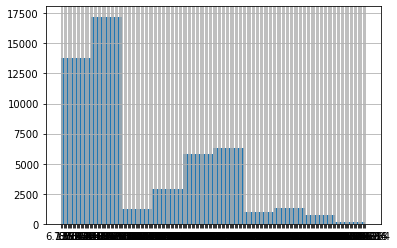

In [8]:
data.Mw.hist()

In [9]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size=0.2)
features = ['LAT', 'LONG', 'DEPTH', 'INTENSITY']
# features = ['DEPTH', 'INTENSITY']
X = data[features]
y=data.label
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.20, random_state=1)

In [10]:
# Missing Values
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(train_X))
imputed_X_valid = pd.DataFrame(my_imputer.transform(val_X))

In [11]:
dec_model=DecisionTreeRegressor(random_state=1)
dec_model.fit(imputed_X_train, train_y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [12]:
from sklearn.metrics import mean_absolute_error

val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))
print(val_mae)

Validation MAE when not specifying max_leaf_nodes: 0
0.4329101315325131


In [13]:
dec_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
dec_model.fit(imputed_X_train, train_y)
val_predictions = dec_model.predict(imputed_X_valid)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))
print(val_mae)

Validation MAE for best value of max_leaf_nodes: 0
0.45687281678645275


In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# tree = DecisionTreeClassifier(max_depth=5, random_state=17)
# knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=100, random_state=17)
knn = KNeighborsClassifier(n_neighbors=5)
tree.fit(imputed_X_train, train_y)

# for kNN, we need to scale features
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(imputed_X_train)
val_X_scaled = scaler.transform(imputed_X_valid)
knn.fit(train_X_scaled, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [15]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(imputed_X_valid)
accuracy_score(val_y, tree_pred) 

0.5697301377618419

In [16]:
knn_pred = knn.predict(val_X_scaled)
accuracy_score(val_y, knn_pred)

0.583223249669749

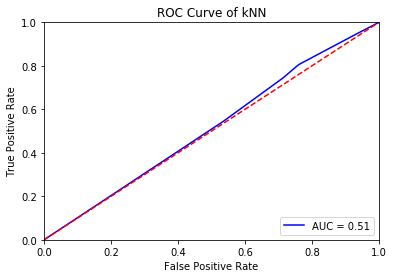

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# ROC with K as parameter in KNN
# knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(train_X_scaled, train_y)

y_scores = knn.predict_proba(imputed_X_valid)
fpr, tpr, threshold = roc_curve(val_y, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('KNN Classifier on Indian Earthquakes')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [22]:
from sklearn.tree.export import export_text
tree_rules = export_text(tree, feature_names=list(train_X))
print(tree_rules)

|--- LONG <= 9.51
|   |--- DEPTH <= 0.75
|   |   |--- LAT <= 96.90
|   |   |   |--- LAT <= 66.99
|   |   |   |   |--- LONG <= 2.49
|   |   |   |   |   |--- LAT <= 65.88
|   |   |   |   |   |   |--- LONG <= 2.12
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- LONG >  2.12
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- LAT >  65.88
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- LONG >  2.49
|   |   |   |   |   |--- LAT <= 66.41
|   |   |   |   |   |   |--- LAT <= 66.31
|   |   |   |   |   |   |   |--- LONG <= 2.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- LONG >  2.50
|   |   |   |   |   |   |   |   |--- LONG <= 3.64
|   |   |   |   |   |   |   |   |   |--- LAT <= 65.13
|   |   |   |   |   |   |   |   |   |   |--- LONG <= 3.53
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- LONG >  3.53
|   |   |   |   |   |   |   |   |   |   |   |--- truncate

/home/masterg/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
